# eBay Pokémon Collectibles Scraper

This project provides a Python-based scraper designed to extract and analyze Pokémon collectible listings from the [eBay website](https://www.ebay.com/b/Sealed-Collectible-Card-Game-Packs/183456/bn_1893736). By automating data collection, this scraper facilitates efficient analysis and visualization of collectible details, including titles, images, prices, shipping costs, and sales data. By using libraries like `selenium`, `beautifulsoup4`, and `pandas`, the scraper retrieves, processes, and transforms the data into a structured format for further insights.

## Data Extraction
The scraper uses Selenium to navigate through multiple pages of listings and BeautifulSoup to parse the HTML content. It processes the data to extract relevant information such as titles, images, prices, and sales data.

In [ ]:
# Imports
from selenium import webdriver
from currency_converter import CurrencyConverter
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import pandas as pd
import time

In [ ]:
def get_soup_from_driver(driver):
    """Get a BeautifulSoup object from a Selenium WebDriver"""
    return bs(driver.page_source, 'html.parser')

def get_product_details(driver):
    """Extract product details"""
    products = []
    base_url = "https://www.ebay.com/b/Pokemon-TCG/2536/bn_7117595258"
    
    # Navigate the first five pages
    for page in range(1, 5):
        # Parse the loaded page
        url = f"{base_url}?_pgn={page}"
        driver.get(url)
        time.sleep(2)
        soup = get_soup_from_driver(driver)
        
        # Find all product elements
        link_elements = soup.find_all('a', class_='bsig__title__wrapper')
        title_elements = soup.find_all('h3', class_='textual-display bsig__title__text')
        price_elements = soup.find_all('span', class_='textual-display bsig__price bsig__price--displayprice')
        logistic_elements = soup.find_all('span', class_='textual-display bsig__generic bsig__logisticsCost')
        delivery_elements = soup.find_all('span', class_='textual-display bsig__generic bsig__deliveryOptions bold')
        sold_elements = soup.find_all('span', class_='textual-display negative')
        image_elements = soup.find_all('img', class_='brwrvr__item-card__image')
        
        # Determine the minimum length to avoid index errors
        min_length = min(len(title_elements), len(link_elements), len(price_elements), len(logistic_elements), len(sold_elements))
        
        # Extract text or attributes from the first element only
        for i in range(min_length):
            link = link_elements[i]['href']
            title = title_elements[i].text.strip()
            price = price_elements[i].text.strip()
            logistics = logistic_elements[i].text.strip()
            delivery = delivery_elements[i].text.strip() if i < len(delivery_elements) else None
            sold = sold_elements[i].text.strip() if i < len(sold_elements) else None
            image = image_elements[i]['src']
            
            products.append((title, image, link, price, logistics, delivery, sold))
    
    return products

# Set up Selenium WebDriver (in this case Chrome)
driver = webdriver.Chrome()

# Get product details
product_details = get_product_details(driver)

# Convert to DataFrame
df = pd.DataFrame(product_details, columns=['Title', 'Image', 'Link', 'Price (USD)', 'Shipping Cost (USD)', 'Delivery', 'Amount Sold'])

# Close the driver
driver.quit()

In [224]:
# Display the DataFrame
df.head()

,Title,Image,Link,Price (USD),Shipping Cost (USD),Delivery,Amount Sold
0,Pokemon SV9 Journey Together Enhanced Booster ...,https://i.ebayimg.com/thumbs/images/g/4x0AAeSw...,https://www.ebay.com/itm/156759169279?itmmeta=...,"ZAR 4,397.26",Free shipping,"Thu, Apr 3",446 sold
1,Pokemon x36 Factory Sealed Booster Packs EVOLV...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/itm/325248393954?itmmeta=...,"ZAR 4,580.49",Free shipping,"Fri, Apr 4","1,614 sold"
2,POKEMON THE GLORY OF TEAM ROCKET - SV10 JAPANE...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/itm/356715350225?itmmeta=...,"ZAR 3,389.70",Free shipping,"Thu, Apr 3",338 sold
3,"Pokemon 151 Singles - Reverse Holo, Full Arts,...",https://i.ebayimg.com/thumbs/images/g/4RUAAOSw...,https://www.ebay.com/itm/176105703833?itmmeta=...,"ZAR 18.14 to ZAR 5,313.22",ZAR 18.32 shipping,"Thu, Apr 3",200 sold
4,Pokemon Scarlet & Violet Journey Together Enha...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/p/25063574029?iid=1870911...,"ZAR 4,303.64",Free shipping,"Thu, Apr 3","5,851 sold"


## Data Preprocessing

The extracted data is processed to remove any missing values and unnecessary columns or rows, enhancing its usability for the end user. 

In [225]:
# Check missing values
print("\nMissing values: ")
print(df.isna().sum())


Missing values: 
Title                    0
Image                    0
Link                     0
Price (USD)              0
Shipping Cost (USD)      0
Delivery               154
Amount Sold              0
dtype: int64


In [226]:
# Fill missing values
df_copy = df.copy()
df_copy['Delivery'] = df_copy['Delivery'].fillna('Not Available')
print("\nMissing values: ")
print(df_copy.isna().sum())


Missing values: 
Title                  0
Image                  0
Link                   0
Price (USD)            0
Shipping Cost (USD)    0
Delivery               0
Amount Sold            0
dtype: int64


In [227]:
# Convert currency to dollars
c = CurrencyConverter()

def extract_max_price_and_convert(price_str):
    # Remove 'ZAR' and split the string
    price_range = price_str.replace('ZAR', '').split('to')
    # Convert the prices to floats and get the maximum value
    price_zar = max(float(price.strip().replace(',', '')) for price in price_range)
    # Convert the maximum ZAR price to USD
    price_usd = c.convert(price_zar, 'ZAR', 'USD')
    return price_usd

# Apply the function to the 'Price' column
df_copy['Price (USD)'] = df_copy['Price (USD)'].apply(extract_max_price_and_convert).round(2)

In [228]:
# Convert shipping cost to USD
def convert_shipping_to_usd(shipping_str):
    if 'Free shipping' in shipping_str:
        return 0.0
    else:
        shipping_zar = float(shipping_str.replace('ZAR', '').replace('shipping', '').strip())
        shipping_usd = c.convert(shipping_zar, 'ZAR', 'USD')
        return shipping_usd

# Apply the conversion function to the 'Shipping' column
df_copy['Shipping Cost (USD)'] = df_copy['Shipping Cost (USD)'].apply(convert_shipping_to_usd).round(2)

In [229]:
# Remove the text 'sold' and commas, and strip whitespace
df_copy['Amount Sold'] = df_copy['Amount Sold'].str.replace('sold', '').str.replace(',', '').str.strip()
df_copy = df_copy[df_copy['Amount Sold'].str.isnumeric()]
df_copy['Amount Sold'] = df_copy['Amount Sold'].astype(float)

In [230]:
df_copy.head()

,Title,Image,Link,Price (USD),Shipping Cost (USD),Delivery,Amount Sold
0,Pokemon SV9 Journey Together Enhanced Booster ...,https://i.ebayimg.com/thumbs/images/g/4x0AAeSw...,https://www.ebay.com/itm/156759169279?itmmeta=...,240.27,0.0,"Thu, Apr 3",446.0
1,Pokemon x36 Factory Sealed Booster Packs EVOLV...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/itm/325248393954?itmmeta=...,250.28,0.0,"Fri, Apr 4",1614.0
2,POKEMON THE GLORY OF TEAM ROCKET - SV10 JAPANE...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/itm/356715350225?itmmeta=...,185.22,0.0,"Thu, Apr 3",338.0
3,"Pokemon 151 Singles - Reverse Holo, Full Arts,...",https://i.ebayimg.com/thumbs/images/g/4RUAAOSw...,https://www.ebay.com/itm/176105703833?itmmeta=...,290.32,1.0,"Thu, Apr 3",200.0
4,Pokemon Scarlet & Violet Journey Together Enha...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/p/25063574029?iid=1870911...,235.16,0.0,"Thu, Apr 3",5851.0


In [231]:
# Reformat dataframe
df_copy = df_copy.reindex(columns=['Title', 'Image', 'Link', 'Price (USD)', 'Shipping Cost (USD)', 'Delivery', 'Amount Sold'])
df_copy.head()

,Title,Image,Link,Price (USD),Shipping Cost (USD),Delivery,Amount Sold
0,Pokemon SV9 Journey Together Enhanced Booster ...,https://i.ebayimg.com/thumbs/images/g/4x0AAeSw...,https://www.ebay.com/itm/156759169279?itmmeta=...,240.27,0.0,"Thu, Apr 3",446.0
1,Pokemon x36 Factory Sealed Booster Packs EVOLV...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/itm/325248393954?itmmeta=...,250.28,0.0,"Fri, Apr 4",1614.0
2,POKEMON THE GLORY OF TEAM ROCKET - SV10 JAPANE...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/itm/356715350225?itmmeta=...,185.22,0.0,"Thu, Apr 3",338.0
3,"Pokemon 151 Singles - Reverse Holo, Full Arts,...",https://i.ebayimg.com/thumbs/images/g/4RUAAOSw...,https://www.ebay.com/itm/176105703833?itmmeta=...,290.32,1.0,"Thu, Apr 3",200.0
4,Pokemon Scarlet & Violet Journey Together Enha...,https://ir.ebaystatic.com/cr/v/c1/s_1x2.gif,https://www.ebay.com/p/25063574029?iid=1870911...,235.16,0.0,"Thu, Apr 3",5851.0


#### Visualization for usability testing

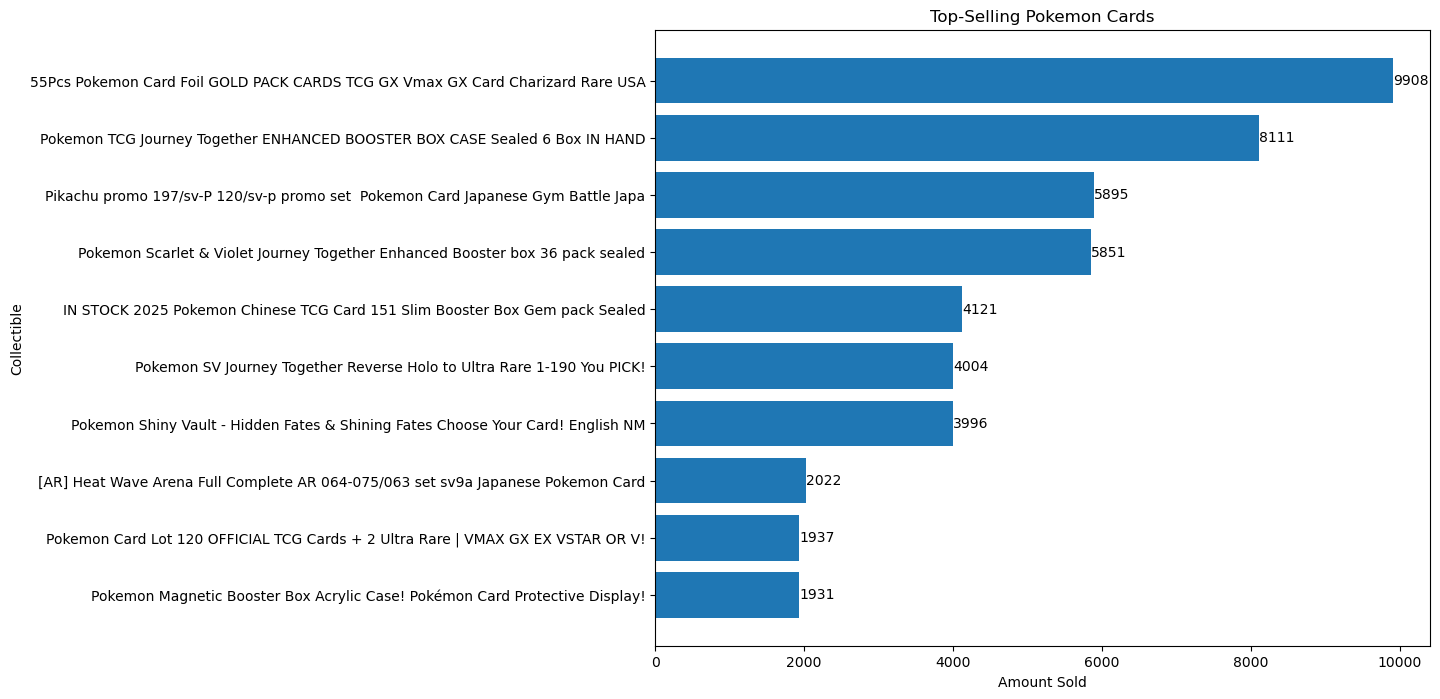

In [233]:
# Convert the 'Amount Sold' column to an integer
df_copy['Amount Sold'] = df_copy['Amount Sold'].astype(float)
top_selling = df_copy.sort_values(by='Amount Sold', ascending=False).head(10)
plt.figure(figsize=(10, 8))
bplot = plt.barh(top_selling['Title'], top_selling['Amount Sold'])
plt.title('Top-Selling Pokemon Cards')
plt.xlabel('Amount Sold')
plt.ylabel('Collectible')
plt.gca().invert_yaxis()
plt.bar_label(bplot)
plt.show()

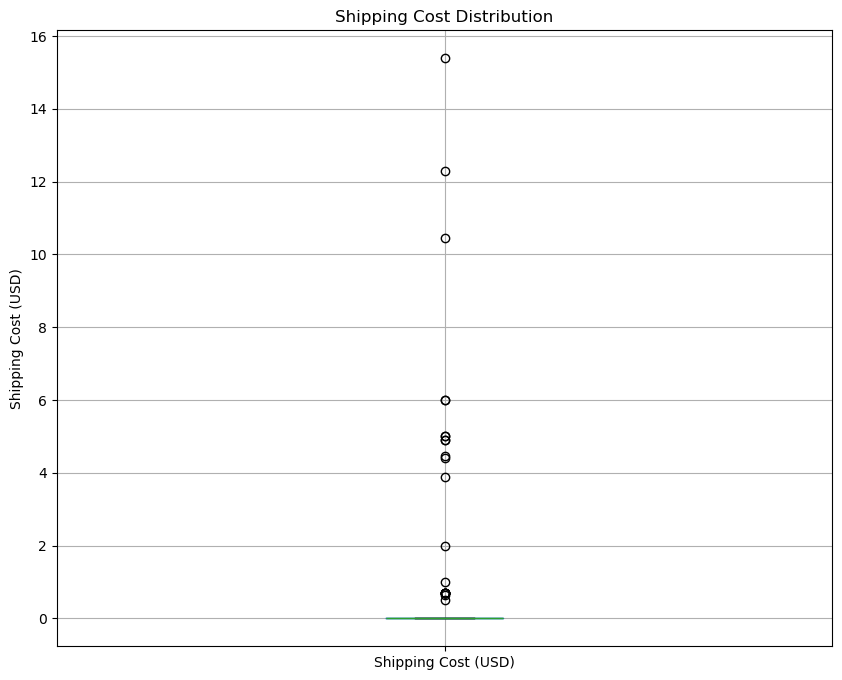

In [234]:
plt.figure(figsize=(10, 8))
df_copy.boxplot(column='Shipping Cost (USD)')
plt.title('Shipping Cost Distribution')
plt.ylabel('Shipping Cost (USD)')
plt.grid(True)
plt.show()

## Data Exporting

The processed data is exported to both Excel and CSV formats. This allows analysts to perform further analysis using spreadsheet software or import the data into other analytical tools.

In [ ]:
# File names
csv_file = 'pokemon_cards_data.csv'
excel_file = 'pokemon_cards_data.xlsx'

# Export to CSV
try:
    df_copy.to_csv(csv_file, index=False)
    print(f"Data exported to {csv_file}")
except PermissionError as e:
    print(f"Permission error while writing to {csv_file}: {e}")

# Export to Excel
try:
    df_copy.to_excel(excel_file, index=False, sheet_name='eBay Listings')
    print(f"Data exported to {excel_file}")
except PermissionError as e:
    print(f"Permission error while writing to {excel_file}: {e}")

Data exported to pokemon_cards_data.csv
Data exported to pokemon_cards_data.xlsx
